In [141]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import re
from gimmemotifs.motif import Motif,read_motifs

from pyInfinityFlow.InfinityFlow_Utilities import pearson_corr_df_to_df
from pyInfinityFlow.InfinityFlow_Utilities import marker_finder

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2023_06_12_tea_seq_atac_processing/")

%matplotlib inline  

In [2]:
# Read in the CITE-seq RNA counts
path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

adata_cite = sc.read(os.path.join(\
    path_cite_data, 
    "cite_seq_adata_rna_combined.h5ad"))
print("Computing CPTT normalized scRNA-seq from CITE-seq...")
adata_cite.X = np.log2((10000 * (adata_cite.X.T / \
    adata_cite.X.sum(axis=1).T).T) + 1)
cite_cell_anno = pd.read_csv(os.path.join(\
    path_cite_data, 
    "cite_seq_cell_annotations.csv"))
cite_cell_anno.index = cite_cell_anno["Cell_Barcode"].values

# Make pseudobulk RNA counts from cite clusters
print("Computing RNA centroids...")
shared_cells_cite = np.intersect1d(cite_cell_anno.index.values, 
    adata_cite.obs.index.values)
cite_cell_anno = cite_cell_anno.loc[shared_cells_cite]
cite_rna = {}
for tmp_cluster in cite_cell_anno["sctri_cite"].unique():
    print("\t{}...".format(tmp_cluster))
    tmp_barcodes = cite_cell_anno.loc[\
        cite_cell_anno["sctri_cite"] == tmp_cluster].index.values
    cite_rna[tmp_cluster] = pd.Series(np.asarray(\
            adata_cite[tmp_barcodes].X.mean(axis=0)).reshape(-1),
            index=adata_cite.var.index.values)

cite_rna = pd.DataFrame(cite_rna)
cite_rna = cite_rna.drop("Unknown", axis=1)
# map_r7_names = pd.read_csv(os.path.join(\
#     path_cite_data, 
#     "map_r7-v1_to_r7-v2_names.csv"))
# map_r7_names_v1_to_v2 = pd.Series(\
#     map_r7_names["R7_V2"].values,
#     index = map_r7_names["R7_V1"].values)

# cite_rna = cite_rna.rename(map_r7_names_v1_to_v2, axis=1)
# cite_rna.columns = [i.replace("-", "_") for i in cite_rna.columns.values]

Computing CPTT normalized scRNA-seq from CITE-seq...
Computing RNA centroids...
	ERP4--Ex...
	MultiLin-2_ML-c9--RNA...
	ERP2_Kit-c14--RNA...
	ERP2--Ex...
	Ebf1+_proB_CD127-c2--RNA...
	proNeu-1_1-4--ADT...
	Unknown...
	preNeu-2_1-8--ADT...
	cMoP_ML-c15--RNA...
	immNeu_Kit-c3--RNA...
	MP--Ex...
	proNeu-2_Kit-c4--RNA...
	Ebf1+_proB--Ex...
	ML_ERP1_ML-c4--RNA...
	MDP--Ex...
	preNeu-3_Kit-c2--RNA...
	ERP4_Kit-c13--RNA...
	preNeu-3_2-3--ADT...
	immNeu_2-5--ADT...
	preNeu-1_Kit-c5--RNA...
	immNeu_Kit-c1--RNA...
	cMoP--Ex...
	neoHPC_Myc--Ex...
	Bcl11b+_preETP--Ex...
	ML_Multi-Lin-2_HSC-c7--RNA...
	Ebf1+_proB_CD127-c8--RNA...
	IG2-proNeu1_ML-c14--RNA...
	ML_Mast--Ex...
	ML_cell_cycle_ML-c5--RNA...
	HSC-HPC-Cenpf_HSC-c12--RNA...
	MultiLin-2_ERP_ML-c10--RNA...
	ML_MDP_ML-c13--RNA...
	proNeu-1--Ex...
	SiglecH-Ly6C-pre-DC--Ex...
	HSC-HPC-Mki67--Ex...
	Pro-B_CD127-c3--RNA...
	precursor_B_cell_5-2--ADT...
	CLP1_CD127-c5--RNA...
	ML_MultiLin-1_ML-c8--RNA...
	ETP-A-0-Ccl4--Ex...
	ETP-CC-4-Ung--Ex...
	e

In [3]:
# Read in cluster annotations to map cluster order
path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/"
cluster_anno = pd.read_csv(os.path.join(path_cite_data, "processed_files/"\
    "cluster_anno_r6_r7_lvl4_and_order.csv"))
map_lvl4_to_order = pd.Series(\
    cluster_anno["Order"].values,
    index=cluster_anno["lvl4"].values).dropna().astype(int)
map_lvl4_to_color = pd.Series(\
    cluster_anno["Color"].values,
    index = cluster_anno["lvl4"].values)
map_r7_to_lvl4 = pd.Series(\
    cluster_anno["lvl4"].values,
    index=cluster_anno["R7"].values)
map_lvl4_to_order

qHSC           1
aHSC           2
HSC-Ly         3
MPP5-IER       4
MPP5 Ly-I      5
              ..
ILCP-b        83
ILC2          84
ILC1_3+NKP    85
pre-aceNKP    86
aceNKP        87
Length: 87, dtype: int64

In [74]:
inflow_pbulks = pd.read_feather("input/infinityflow/"\
    "infinityflow_even_sampled_indices_centroid_values_across_r7.fea")
inflow_pbulks = inflow_pbulks.set_index("index")
inflow_pbulks.index = [map_r7_to_lvl4[i] for i in inflow_pbulks.index.values]
inflow_pbulks

CD105     CD106     CD117     CD11b     CD125     CD127  \
proB-cycling  0.376555  0.263200  0.397779  0.292468  0.253649  0.457868   
BMCP          0.253467  0.307926  0.453045  0.306266  0.263218  0.226779   
pre-Baso      0.249247  0.314707  0.409249  0.313781  0.237839  0.220175   
ILC1_3+NKP    0.277550  0.284606  0.319559  0.314662  0.331313  0.318120   
pre-aceNKP    0.257753  0.257858  0.316652  0.307485  0.245151  0.269675   
...                ...       ...       ...       ...       ...       ...   
preNeu-3c     0.256215  0.347076  0.350689  0.648551  0.267531  0.272632   
preNeu-2      0.261840  0.305829  0.335847  0.572047  0.258484  0.251097   
proNeu-1a     0.253101  0.299526  0.442861  0.377628  0.254277  0.259052   
proNeu-1b     0.251680  0.302749  0.431564  0.451581  0.261518  0.268026   
proNeu-2      0.249828  0.453839  0.407805  0.526417  0.266683  0.265456   

                 CD131     CD135     CD150   CD16_32  ...  Imputed_TSLPR  \
proB-cycling  0.261040  0.402473  0.260477  0.308028  ...       0.385983   
BMCP          0.322621  0.239928  0.244789  0.427799  ...       0.424002   
pre-Baso      0.423441  0.236582  0.240799  0.461349  ...       0.450536   
ILC1_3+NKP    0.264614  0.272507  0.244297  0.286276  ...       0.347208   
pre-aceNKP    0.251178  0.246870  0.278100  0.260225  ...       0.351793   
...                ...       ...       ...       ...  ...            ...   
preNeu-3c     0.243181  0.247681  0.250652  0.424529  ...       0.326037   
preNeu-2      0.279274  0.251639  0.253204  0.403467  ...       0.338602   
proNeu-1a     0.268759  0.256716  0.251452  0.434832  ...       0.334912   
proNeu-1b     0.285747  0.256520  0.258177  0.445826  ...       0.322434   
proNeu-2      0.271610  0.274755  0.260148  0.441135  ...       0.335812   

              Imputed_Tcf7_GFP  Imputed_Tox-tdTomato  Imputed_VISTA  \
proB-cycling          0.256177              0.239335       0.461280   
BMCP                  0.345405              0.248782       0.484708   
pre-Baso              0.323940              0.248986       0.503939   
ILC1_3+NKP            0.320404              0.264964       0.515335   
pre-aceNKP            0.358340              0.233224       0.490008   
...                        ...                   ...            ...   
preNeu-3c             0.270707              0.218609       0.681029   
preNeu-2              0.253087              0.230261       0.674672   
proNeu-1a             0.300628              0.229442       0.548764   
proNeu-1b             0.293324              0.211900       0.595158   
proNeu-2              0.312868              0.242592       0.634606   

              Imputed_Wnt_GFP      Irf8  Lin_Strep      Ly6C      Ly6G  \
proB-cycling         0.224286  0.529861   0.553436  0.277206  0.252574   
BMCP                 0.234992  0.301322   0.273668  0.264106  0.260383   
pre-Baso             0.230149  0.266538   0.267361  0.270840  0.267451   
ILC1_3+NKP           0.245155  0.369096   0.394605  0.268499  0.226473   
pre-aceNKP           0.234299  0.423079   0.592612  0.383347  0.248830   
...                       ...       ...        ...       ...       ...   
preNeu-3c            0.232447  0.252358   0.257567  0.523554  0.331062   
preNeu-2             0.217832  0.249554   0.255720  0.455695  0.494314   
proNeu-1a            0.250321  0.291476   0.277654  0.496368  0.251988   
proNeu-1b            0.259426  0.336458   0.275074  0.586070  0.252608   
proNeu-2             0.245125  0.274948   0.283191  0.545421  0.239254   

                   Sca  
proB-cycling  0.428651  
BMCP          0.272486  
pre-Baso      0.270120  
ILC1_3+NKP    0.521263  
pre-aceNKP    0.325282  
...                ...  
preNeu-3c     0.286944  
preNeu-2      0.279672  
proNeu-1a     0.271542  
proNeu-1b     0.279713  
proNeu-2      0.272642  

[88 rows x 135 columns]

In [75]:
inflow_pbulks.columns.values

array(['CD105', 'CD106', 'CD117', 'CD11b', 'CD125', 'CD127', 'CD131',
       'CD135', 'CD150', 'CD16_32', 'CD201', 'CD27', 'CD371', 'CD41',
       'CD48', 'CD55', 'CD93', 'CX3CR1', 'DEAD', 'FCER1A', 'ITGB7',
       'Imputed_Bhlhe40-GFP', 'Imputed_CD102', 'Imputed_CD107a',
       'Imputed_CD115', 'Imputed_CD11a', 'Imputed_CD11c', 'Imputed_CD123',
       'Imputed_CD124', 'Imputed_CD126', 'Imputed_CD129', 'Imputed_CD137',
       'Imputed_CD14', 'Imputed_CD140a', 'Imputed_CD155',
       'Imputed_CD159a', 'Imputed_CD160', 'Imputed_CD163',
       'Imputed_CD169', 'Imputed_CD170', 'Imputed_CD172a',
       'Imputed_CD182', 'Imputed_CD183', 'Imputed_CD193', 'Imputed_CD1d',
       'Imputed_CD2', 'Imputed_CD20', 'Imputed_CD200', 'Imputed_CD200R3',
       'Imputed_CD200r', 'Imputed_CD204', 'Imputed_CD205',
       'Imputed_CD213a1', 'Imputed_CD21_35', 'Imputed_CD22',
       'Imputed_CD223', 'Imputed_CD23', 'Imputed_CD24', 'Imputed_CD25',
       'Imputed_CD26', 'Imputed_CD270', 'Imputed_CD274', 'Imp

In [4]:
# Information concerning the cluster specific connection files
path_to_cluster_conns = "output/GRN/all_genes_no_threshold/cluster_specific_tf_links/"
list_clusters = [i.split("_")[0] for i in os.listdir(path_to_cluster_conns)]

In [8]:
tfs_of_interest = ["Spi1", "Gata2", "Gata1", "Myc", "Irf8"]

In [11]:
# Pull out the activites: TF-Gene Pairs
cluster_conns = {}
for i, tmp_cluster in enumerate(list_clusters):
    print(f"{i+1}/{len(list_clusters)} Done...", end="\r", flush=True)
    tmp_conns = pd.read_feather(os.path.join(\
        path_to_cluster_conns, 
        f"{tmp_cluster}_conns.fea"))
    cluster_conns[tmp_cluster] = tmp_conns.loc[tmp_conns["TF_con"].isin(\
        tfs_of_interest)]

In [32]:
tf_gene_targets = {}
for tmp_tf in tfs_of_interest:
    tmp_targets = []
    for tmp_cluster in cluster_conns:
        tmp_genes = cluster_conns[tmp_cluster].loc[cluster_conns[tmp_cluster]["TF_con"] == tmp_tf, "Gene"].unique()
        tmp_genes = pd.DataFrame({"gene": tmp_genes})
        tmp_genes["cluster"] = tmp_cluster
        tmp_targets.append(tmp_genes)

    tf_gene_targets[tmp_tf] = pd.concat(tmp_targets)

In [57]:
path_fig1_heatmap_stuff = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/"\
    "analysis/2023_06_14_nominate_regions_for_mpra_assay/output/plots_for_pub/"

rna_data_to_plot = pd.read_csv(os.path.join(\
        path_fig1_heatmap_stuff, 
        "rna_markers_heatmap.csv"), 
    index_col=0)
cell_assignments = pd.read_csv(os.path.join(\
        path_fig1_heatmap_stuff, 
        "cell_assigments_annotation.csv"), 
    index_col=0)
cell_assignments_reorder = cell_assignments.loc[rna_data_to_plot.columns.values]

cell_assignments_reorder["cluster"] = cell_assignments_reorder[\
    "original"].replace(map_r7_to_lvl4.to_dict()).values
cell_assignments_reorder["cluster_order"] = cell_assignments_reorder[\
    "cluster"].replace(map_lvl4_to_order.to_dict()).values
cell_assignments_reorder = cell_assignments_reorder.sort_values(\
    by=["cluster_order", "top_corr"], ascending=[True, False])
cells_to_plot = cell_assignments_reorder.loc[\
    cell_assignments_reorder["cluster"].isin(list_clusters)].copy()
cells_to_plot = cells_to_plot.sort_values(by="cluster_order")
cells_to_plot["barcode"] = [i.split(".")[0] for i in cells_to_plot.index.values]
cells_to_plot["port"] = cells_to_plot["port"].replace({\
    "AS_CITE_Multilin1": "AS_CITE_ML1",
    "AS_CITE_Multilin2": "AS_CITE_ML2"}).values
cells_to_plot.index = (cells_to_plot["port"] + "_" + \
    cells_to_plot["barcode"]).values
cells_to_plot


top_cluster  top_corr      original  \
AS_CITE_HSC_TCGGATAGTGTCACAT-1  LT-HSC_Mllt3  0.929229  LT-HSC_Mllt3   
AS_CITE_HSC_TCATGAGCAGCGGTCT-1  LT-HSC_Mllt3  0.904863  LT-HSC_Mllt3   
AS_CITE_HSC_TCTGTCGTCCGTGTGG-1  LT-HSC_Mllt3  0.904736  LT-HSC_Mllt3   
AS_CITE_HSC_GTCTCACAGCGCTGAA-1  LT-HSC_Mllt3  0.904341  LT-HSC_Mllt3   
AS_CITE_HSC_CCTCAACAGGGCTGAT-1  LT-HSC_Mllt3  0.903068  LT-HSC_Mllt3   
...                                      ...       ...           ...   
AS_CITE_HSC_CAGCCAGAGCACCTGC-1     CLP1-Rrm2  0.890692     CLP1-Rrm2   
AS_CITE_ML1_GTCATTTGTCCTCCAT-1     CLP1-Rrm2  0.889931     CLP1-Rrm2   
AS_CITE_ML1_GCTGCAGTCTCAACGA-1     CLP1-Rrm2  0.889729     CLP1-Rrm2   
AS_CITE_ML2_CCTCCTCCAAGTATAG-1     CLP1-Rrm2  0.893052     CLP1-Rrm2   
AS_CITE_ML2_TAGGAGGTCACCCATC-1     CLP1-Rrm2  0.876018     CLP1-Rrm2   

                                       port port_group cluster cluster_order  \
AS_CITE_HSC_TCGGATAGTGTCACAT-1  AS_CITE_HSC       HSCP    qHSC             1   
AS_CITE_HSC_TCATGAGCAGCGGTCT-1  AS_CITE_HSC       HSCP    qHSC             1   
AS_CITE_HSC_TCTGTCGTCCGTGTGG-1  AS_CITE_HSC       HSCP    qHSC             1   
AS_CITE_HSC_GTCTCACAGCGCTGAA-1  AS_CITE_HSC       HSCP    qHSC             1   
AS_CITE_HSC_CCTCAACAGGGCTGAT-1  AS_CITE_HSC       HSCP    qHSC             1   
...                                     ...        ...     ...           ...   
AS_CITE_HSC_CAGCCAGAGCACCTGC-1  AS_CITE_HSC       HSCP  CLP1-b            67   
AS_CITE_ML1_GTCATTTGTCCTCCAT-1  AS_CITE_ML1   MultiLin  CLP1-b            67   
AS_CITE_ML1_GCTGCAGTCTCAACGA-1  AS_CITE_ML1   MultiLin  CLP1-b            67   
AS_CITE_ML2_CCTCCTCCAAGTATAG-1  AS_CITE_ML2   MultiLin  CLP1-b            67   
AS_CITE_ML2_TAGGAGGTCACCCATC-1  AS_CITE_ML2   MultiLin  CLP1-b            67   

                                           barcode  
AS_CITE_HSC_TCGGATAGTGTCACAT-1  TCGGATAGTGTCACAT-1  
AS_CITE_HSC_TCATGAGCAGCGGTCT-1  TCATGAGCAGCGGTCT-1  
AS_CITE_HSC_TCTGTCGTCCGTGTGG-1  TCTGTCGTCCGTGTGG-1  
AS_CITE_HSC_GTCTCACAGCGCTGAA-1  GTCTCACAGCGCTGAA-1  
AS_CITE_HSC_CCTCAACAGGGCTGAT-1  CCTCAACAGGGCTGAT-1  
...                                            ...  
AS_CITE_HSC_CAGCCAGAGCACCTGC-1  CAGCCAGAGCACCTGC-1  
AS_CITE_ML1_GTCATTTGTCCTCCAT-1  GTCATTTGTCCTCCAT-1  
AS_CITE_ML1_GCTGCAGTCTCAACGA-1  GCTGCAGTCTCAACGA-1  
AS_CITE_ML2_CCTCCTCCAAGTATAG-1  CCTCCTCCAAGTATAG-1  
AS_CITE_ML2_TAGGAGGTCACCCATC-1  TAGGAGGTCACCCATC-1  

[1600 rows x 8 columns]

In [85]:
path_output_figures = "output/FINAL_FIGURES_DIR/inflow_centroids_to_target_gene_heatmaps/"

/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/pandas/core/frame.py:3612: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.n

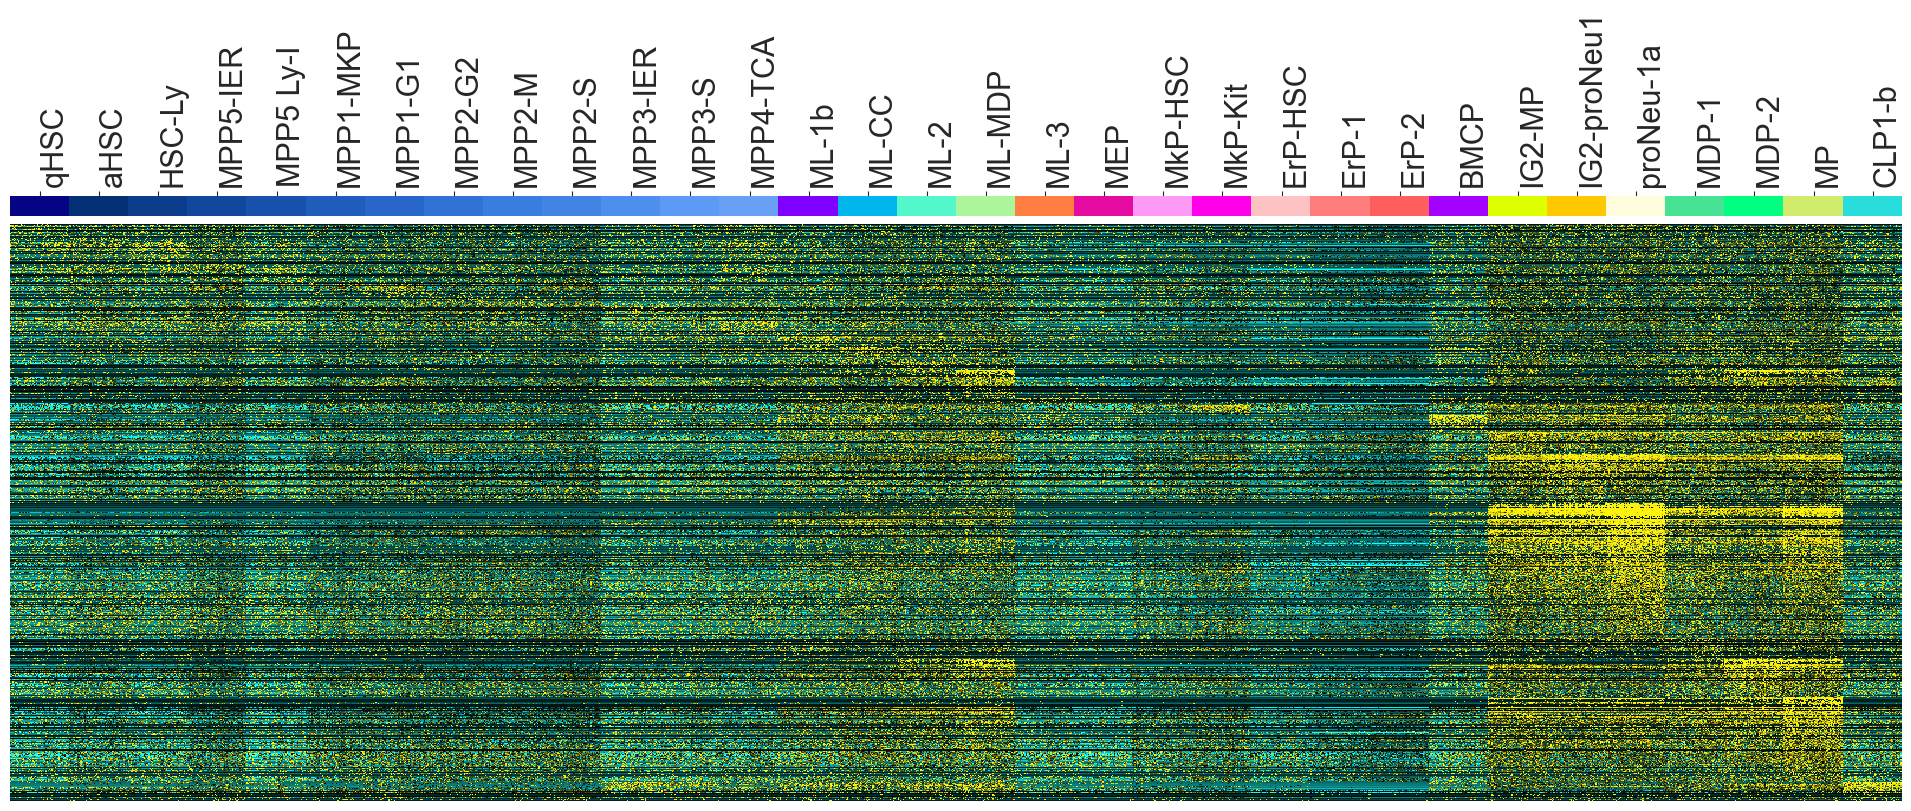

In [108]:
target = "Spi1"

# Define Spi1 markers
list_target_genes = tf_gene_targets["Spi1"]["gene"].unique()
tmp_data = pd.DataFrame(\
    adata_cite[\
        cells_to_plot.index.values, 
        list_target_genes].X.toarray(),
    index=cells_to_plot.index.values,
    columns=list_target_genes)
r_df, p_df = marker_finder(tmp_data, cells_to_plot["cluster"].values)

marker_df = pd.DataFrame({\
    "top_cluster": r_df.idxmax(axis=1),
    "r": r_df.max(axis=1)},
    index=tmp_data.columns.values)
marker_df["cluster_order"] = marker_df["top_cluster"].replace(\
    map_lvl4_to_order.to_dict())
marker_df = marker_df.sort_values(by=["cluster_order", "r"], 
    ascending=[True, False])
marker_df = marker_df.dropna()



# Plot RNA expression heatmap
from pyInfinityFlow.Plotting_Utilities import blue_black_yellow_cmap

plt.rcParams.update({'font.size': 22})

# Prepare cluster label positions
cell_tick_positions = cells_to_plot[["cluster"]]
cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))
cell_tick_positions = pd.pivot_table(\
    cell_tick_positions,
    index = "cluster",
    values = "pos",
    aggfunc = np.mean).sort_values(by="pos")

# RNA data to plot
rna_data_to_plot = zscore(tmp_data.loc[\
    cells_to_plot.index.values, 
    marker_df.index.values].T, axis=1).fillna(0)

# Cluster color bar
plot_cluster_bars = cells_to_plot[["cluster"]].T.copy()
unique_clusters = plot_cluster_bars.loc["cluster"].unique()
map_cluster_to_order = pd.Series(\
    list(range(len(unique_clusters))), 
    index=unique_clusters).to_dict()
plot_cluster_bars.loc["cluster",:] = plot_cluster_bars.loc["cluster"].replace(\
    map_cluster_to_order)
plot_cluster_bars.columns.name = None


# tmp_color_series = pd.Series('#000000', index=map_lvl4_to_color.index.values)
tmp_clusters = cells_to_plot["cluster"].unique()
tmp_color_series = map_lvl4_to_color.loc[tmp_clusters].copy()


# Construct figure
fig = plt.figure(constrained_layout=True, figsize=(19,8))
ax = fig.add_gridspec(150, 1)
ax1 = fig.add_subplot(ax[:5, 0])
ax2 = fig.add_subplot(ax[5:, 0])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap=matplotlib.colors.ListedColormap(\
                            tmp_color_series.values),
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

ax1.set_xticks(\
    ticks = cell_tick_positions["pos"].values,
    labels = cell_tick_positions.index.values, 
    ha="left")
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
    labelrotation=90)

heat2 = sns.heatmap(rna_data_to_plot, 
                        vmin=-1.5, 
                        vmax=1.5, 
                        cmap=blue_black_yellow_cmap,
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False,
                        rasterized=True,
                        ax=ax2)

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.pdf"))

tmp_table_out = pd.concat([\
    pd.DataFrame(cells_to_plot.loc[tmp_data.index.values, "cluster"]),
    tmp_data],
    axis=1)
tmp_table_out.T.to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.csv"),
    header=True, index=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 49 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'd', 'e', 'f', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 41, 42, 43, 44,

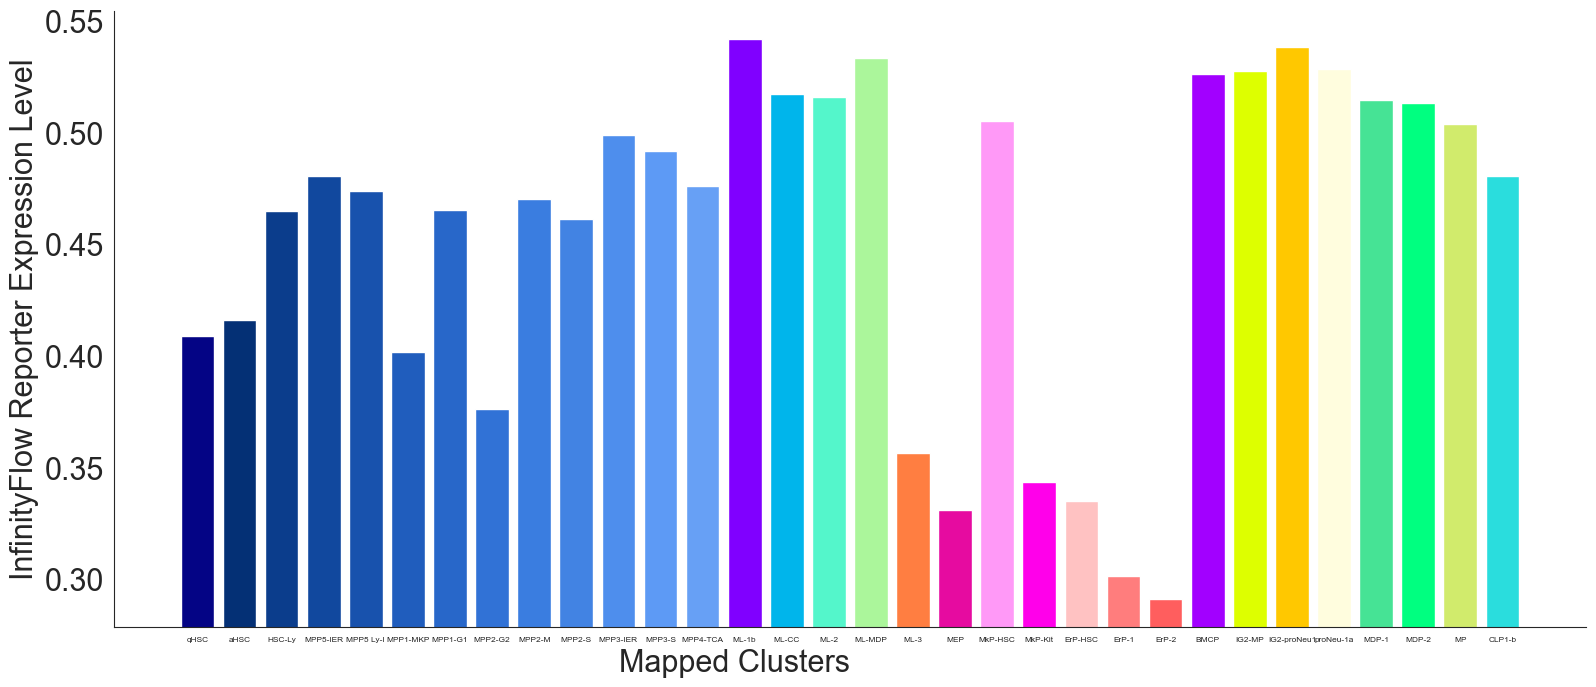

In [110]:
tmp_cluster_list = map_lvl4_to_order.loc[\
    list_clusters].sort_values().index.values
tmp_values = inflow_pbulks.loc[\
    tmp_cluster_list, 
    "Imputed_Pu.1-YFP"]
custom_colors = map_lvl4_to_color[tmp_cluster_list].values
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(19,8))

ax.bar(\
    np.arange(len(tmp_values)), 
    tmp_values, 
    align='center',
    color=custom_colors)

tmp_range = tmp_values.max() - tmp_values.min()
tmp_min = tmp_values.min() - (0.05*tmp_range)
tmp_max = tmp_values.max() + (0.05*tmp_range)

ax.set_ylabel('InfinityFlow Reporter Expression Level')

ax.set_xticks(np.arange(len(tmp_values)))
ax.set_xticklabels(tmp_cluster_list, size=6, ha="center")
ax.set_xlabel("Mapped Clusters", rotation = 0, ha="right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(False)
ax.yaxis.grid(False)
ax.set_ylim((tmp_min,tmp_max))

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.pdf"))

pd.DataFrame(tmp_values).to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.csv"),
    header=True, index=True, index_label="lvl4_cluster")

/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/pandas/core/frame.py:3612: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.n

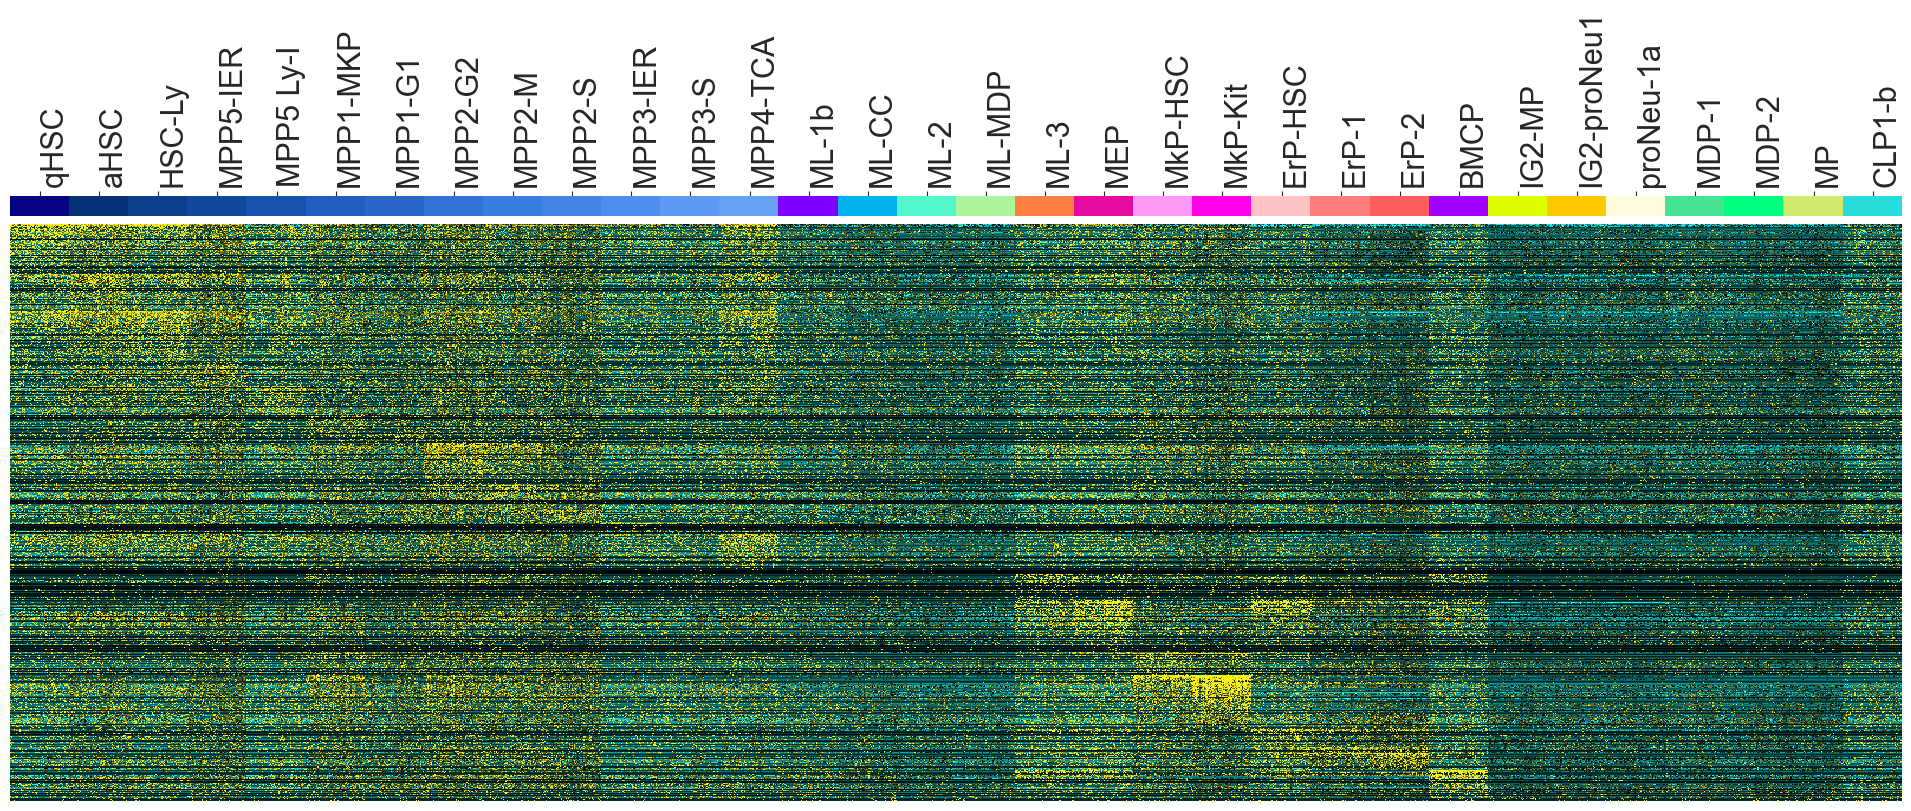

In [111]:
target = "Gata2"

# Define Gata2 markers
list_target_genes = tf_gene_targets["Gata2"]["gene"].unique()
tmp_data = pd.DataFrame(\
    adata_cite[\
        cells_to_plot.index.values, 
        list_target_genes].X.toarray(),
    index=cells_to_plot.index.values,
    columns=list_target_genes)
r_df, p_df = marker_finder(tmp_data, cells_to_plot["cluster"].values)

marker_df = pd.DataFrame({\
    "top_cluster": r_df.idxmax(axis=1),
    "r": r_df.max(axis=1)},
    index=tmp_data.columns.values)
marker_df["cluster_order"] = marker_df["top_cluster"].replace(\
    map_lvl4_to_order.to_dict())
marker_df = marker_df.sort_values(by=["cluster_order", "r"], 
    ascending=[True, False])
marker_df = marker_df.dropna()



# Plot RNA expression heatmap
from pyInfinityFlow.Plotting_Utilities import blue_black_yellow_cmap

plt.rcParams.update({'font.size': 22})

# Prepare cluster label positions
cell_tick_positions = cells_to_plot[["cluster"]]
cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))
cell_tick_positions = pd.pivot_table(\
    cell_tick_positions,
    index = "cluster",
    values = "pos",
    aggfunc = np.mean).sort_values(by="pos")

# RNA data to plot
rna_data_to_plot = zscore(tmp_data.loc[\
    cells_to_plot.index.values, 
    marker_df.index.values].T, axis=1).fillna(0)

# Cluster color bar
plot_cluster_bars = cells_to_plot[["cluster"]].T.copy()
unique_clusters = plot_cluster_bars.loc["cluster"].unique()
map_cluster_to_order = pd.Series(\
    list(range(len(unique_clusters))), 
    index=unique_clusters).to_dict()
plot_cluster_bars.loc["cluster",:] = plot_cluster_bars.loc["cluster"].replace(\
    map_cluster_to_order)
plot_cluster_bars.columns.name = None


# tmp_color_series = pd.Series('#000000', index=map_lvl4_to_color.index.values)
tmp_clusters = cells_to_plot["cluster"].unique()
tmp_color_series = map_lvl4_to_color.loc[tmp_clusters].copy()


# Construct figure
fig = plt.figure(constrained_layout=True, figsize=(19,8))
ax = fig.add_gridspec(150, 1)
ax1 = fig.add_subplot(ax[:5, 0])
ax2 = fig.add_subplot(ax[5:, 0])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap=matplotlib.colors.ListedColormap(\
                            tmp_color_series.values),
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

ax1.set_xticks(\
    ticks = cell_tick_positions["pos"].values,
    labels = cell_tick_positions.index.values, 
    ha="left")
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
    labelrotation=90)

heat2 = sns.heatmap(rna_data_to_plot, 
                        vmin=-1.5, 
                        vmax=1.5, 
                        cmap=blue_black_yellow_cmap,
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False,
                        rasterized=True,
                        ax=ax2)

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.pdf"))

tmp_table_out = pd.concat([\
    pd.DataFrame(cells_to_plot.loc[tmp_data.index.values, "cluster"]),
    tmp_data],
    axis=1)
tmp_table_out.T.to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.csv"),
    header=True, index=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 50 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'd', 'e', 'f', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 26, 36, 37, 38, 39, 40, 41

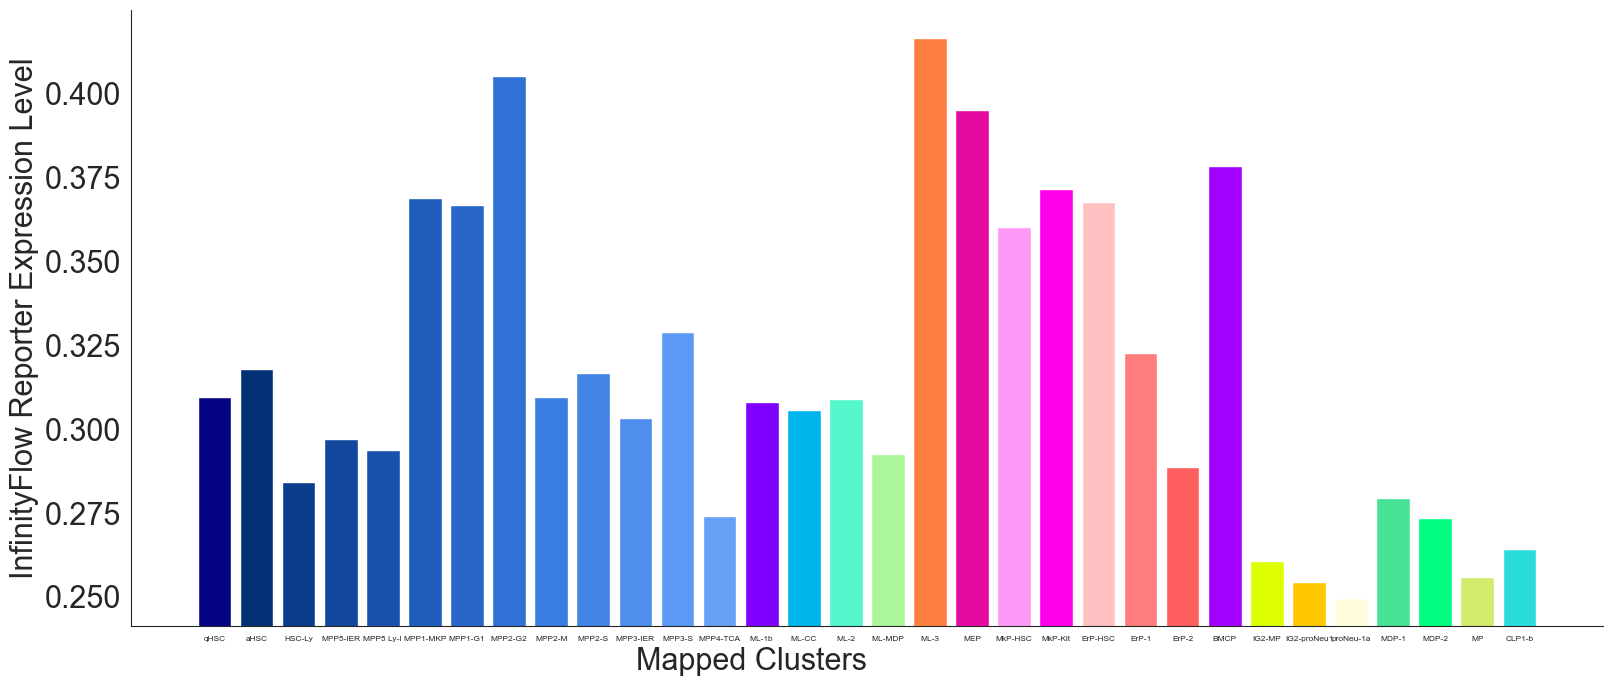

In [112]:
tmp_cluster_list = map_lvl4_to_order.loc[\
    list_clusters].sort_values().index.values
tmp_values = inflow_pbulks.loc[\
    tmp_cluster_list, 
    "Imputed_Gata2-Venus"]
custom_colors = map_lvl4_to_color[tmp_cluster_list].values
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(19,8))

ax.bar(\
    np.arange(len(tmp_values)), 
    tmp_values, 
    align='center',
    color=custom_colors)

tmp_range = tmp_values.max() - tmp_values.min()
tmp_min = tmp_values.min() - (0.05*tmp_range)
tmp_max = tmp_values.max() + (0.05*tmp_range)

ax.set_ylabel('InfinityFlow Reporter Expression Level')

ax.set_xticks(np.arange(len(tmp_values)))
ax.set_xticklabels(tmp_cluster_list, size=6, ha="center")
ax.set_xlabel("Mapped Clusters", rotation = 0, ha="right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(False)
ax.yaxis.grid(False)
ax.set_ylim((tmp_min,tmp_max))

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.pdf"))

pd.DataFrame(tmp_values).to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.csv"),
    header=True, index=True, index_label="lvl4_cluster")

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'e', 'five', 'four', 'hyphen', 'i', 'k', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 'space', 't', 'three', 'two', 'u', 'y']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 51, 53, 54, 55, 68, 69, 72, 76, 78, 82, 83, 84, 85, 87, 88

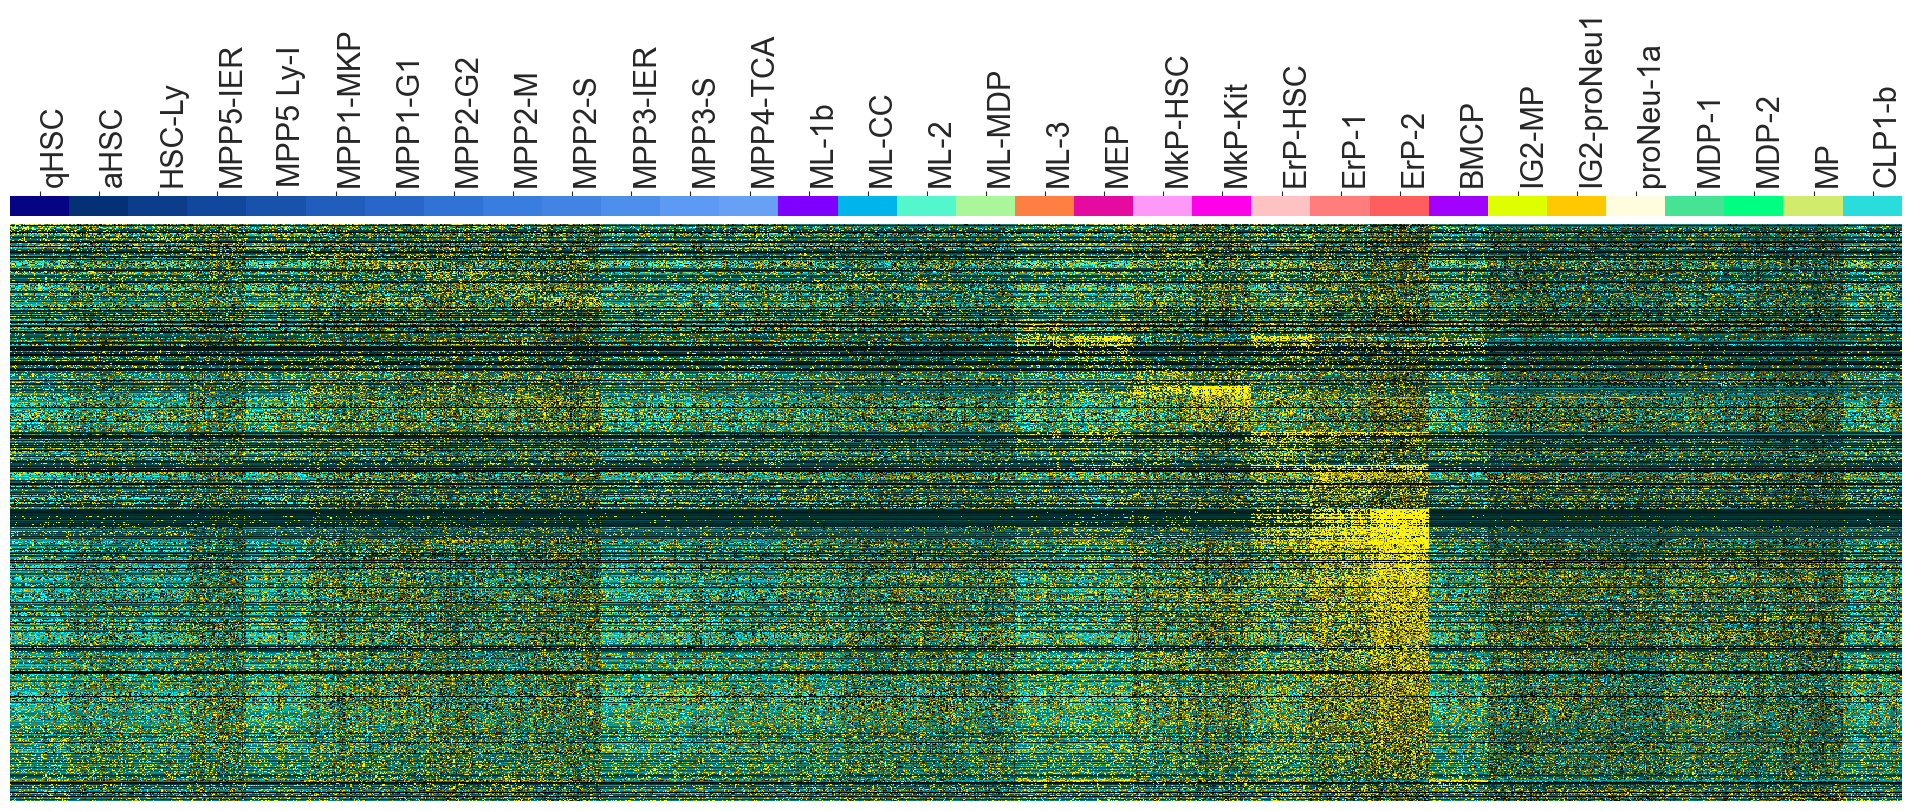

In [113]:
target = "Gata1"

# Define Gata1 markers
list_target_genes = tf_gene_targets["Gata1"]["gene"].unique()
tmp_data = pd.DataFrame(\
    adata_cite[\
        cells_to_plot.index.values, 
        list_target_genes].X.toarray(),
    index=cells_to_plot.index.values,
    columns=list_target_genes)
r_df, p_df = marker_finder(tmp_data, cells_to_plot["cluster"].values)

marker_df = pd.DataFrame({\
    "top_cluster": r_df.idxmax(axis=1),
    "r": r_df.max(axis=1)},
    index=tmp_data.columns.values)
marker_df["cluster_order"] = marker_df["top_cluster"].replace(\
    map_lvl4_to_order.to_dict())
marker_df = marker_df.sort_values(by=["cluster_order", "r"], 
    ascending=[True, False])
marker_df = marker_df.dropna()



# Plot RNA expression heatmap
from pyInfinityFlow.Plotting_Utilities import blue_black_yellow_cmap

plt.rcParams.update({'font.size': 22})

# Prepare cluster label positions
cell_tick_positions = cells_to_plot[["cluster"]]
cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))
cell_tick_positions = pd.pivot_table(\
    cell_tick_positions,
    index = "cluster",
    values = "pos",
    aggfunc = np.mean).sort_values(by="pos")

# RNA data to plot
rna_data_to_plot = zscore(tmp_data.loc[\
    cells_to_plot.index.values, 
    marker_df.index.values].T, axis=1).fillna(0)

# Cluster color bar
plot_cluster_bars = cells_to_plot[["cluster"]].T.copy()
unique_clusters = plot_cluster_bars.loc["cluster"].unique()
map_cluster_to_order = pd.Series(\
    list(range(len(unique_clusters))), 
    index=unique_clusters).to_dict()
plot_cluster_bars.loc["cluster",:] = plot_cluster_bars.loc["cluster"].replace(\
    map_cluster_to_order)
plot_cluster_bars.columns.name = None


# tmp_color_series = pd.Series('#000000', index=map_lvl4_to_color.index.values)
tmp_clusters = cells_to_plot["cluster"].unique()
tmp_color_series = map_lvl4_to_color.loc[tmp_clusters].copy()


# Construct figure
fig = plt.figure(constrained_layout=True, figsize=(19,8))
ax = fig.add_gridspec(150, 1)
ax1 = fig.add_subplot(ax[:5, 0])
ax2 = fig.add_subplot(ax[5:, 0])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap=matplotlib.colors.ListedColormap(\
                            tmp_color_series.values),
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

ax1.set_xticks(\
    ticks = cell_tick_positions["pos"].values,
    labels = cell_tick_positions.index.values, 
    ha="left")
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
    labelrotation=90)

heat2 = sns.heatmap(rna_data_to_plot, 
                        vmin=-1.5, 
                        vmax=1.5, 
                        cmap=blue_black_yellow_cmap,
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False,
                        rasterized=True,
                        ax=ax2)

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.pdf"))

tmp_table_out = pd.concat([\
    pd.DataFrame(cells_to_plot.loc[tmp_data.index.values, "cluster"]),
    tmp_data],
    axis=1)
tmp_table_out.T.to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.csv"),
    header=True, index=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 49 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'd', 'e', 'f', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 41, 42, 43, 44,

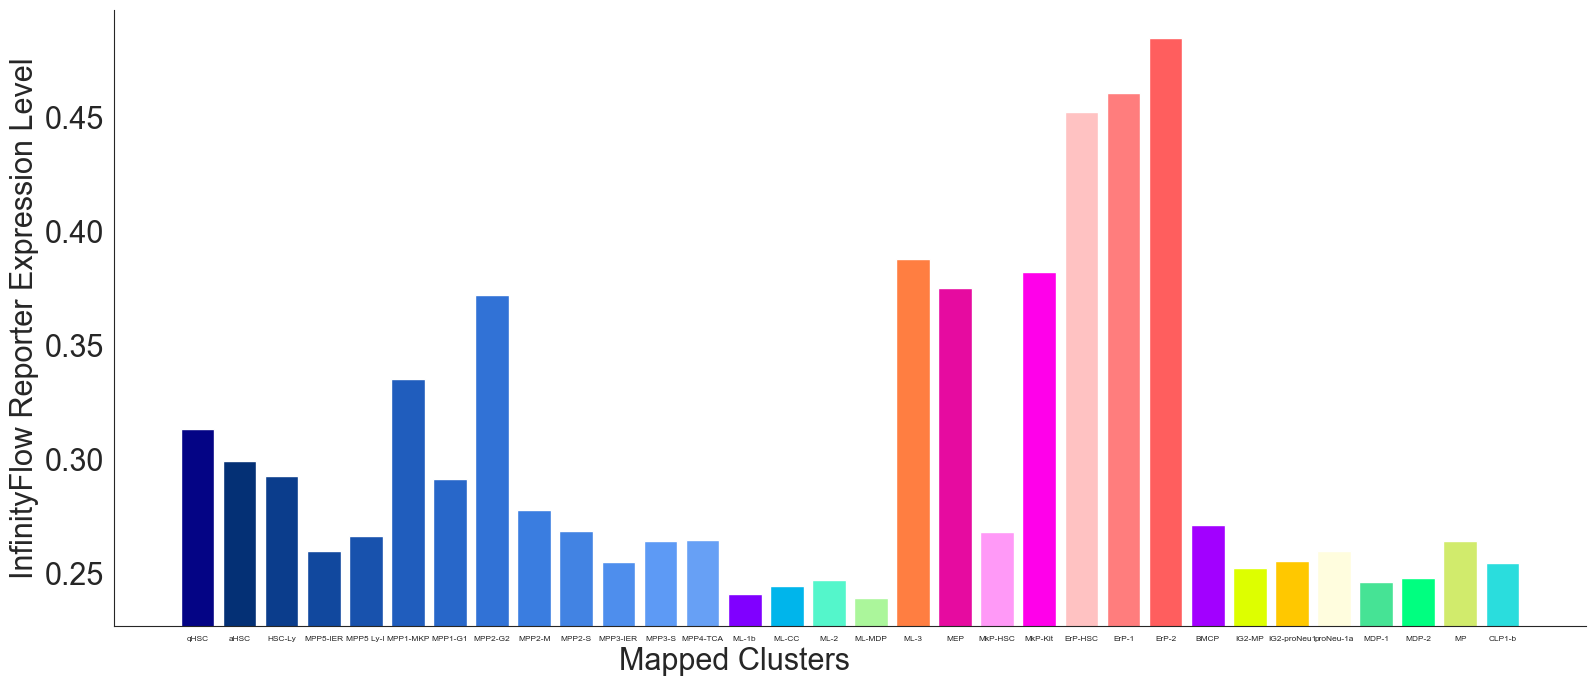

In [114]:
tmp_cluster_list = map_lvl4_to_order.loc[\
    list_clusters].sort_values().index.values
tmp_values = inflow_pbulks.loc[\
    tmp_cluster_list, 
    "Imputed_Gata1-mCherry"]
custom_colors = map_lvl4_to_color[tmp_cluster_list].values
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(19,8))

ax.bar(\
    np.arange(len(tmp_values)), 
    tmp_values, 
    align='center',
    color=custom_colors)

tmp_range = tmp_values.max() - tmp_values.min()
tmp_min = tmp_values.min() - (0.05*tmp_range)
tmp_max = tmp_values.max() + (0.05*tmp_range)

ax.set_ylabel('InfinityFlow Reporter Expression Level')

ax.set_xticks(np.arange(len(tmp_values)))
ax.set_xticklabels(tmp_cluster_list, size=6, ha="center")
ax.set_xlabel("Mapped Clusters", rotation = 0, ha="right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(False)
ax.yaxis.grid(False)
ax.set_ylim((tmp_min,tmp_max))

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.pdf"))

pd.DataFrame(tmp_values).to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.csv"),
    header=True, index=True, index_label="lvl4_cluster")

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'e', 'five', 'four', 'hyphen', 'i', 'k', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 'space', 't', 'three', 'two', 'u', 'y']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 51, 53, 54, 55, 68, 69, 72, 76, 78, 82, 83, 84, 85, 87, 88

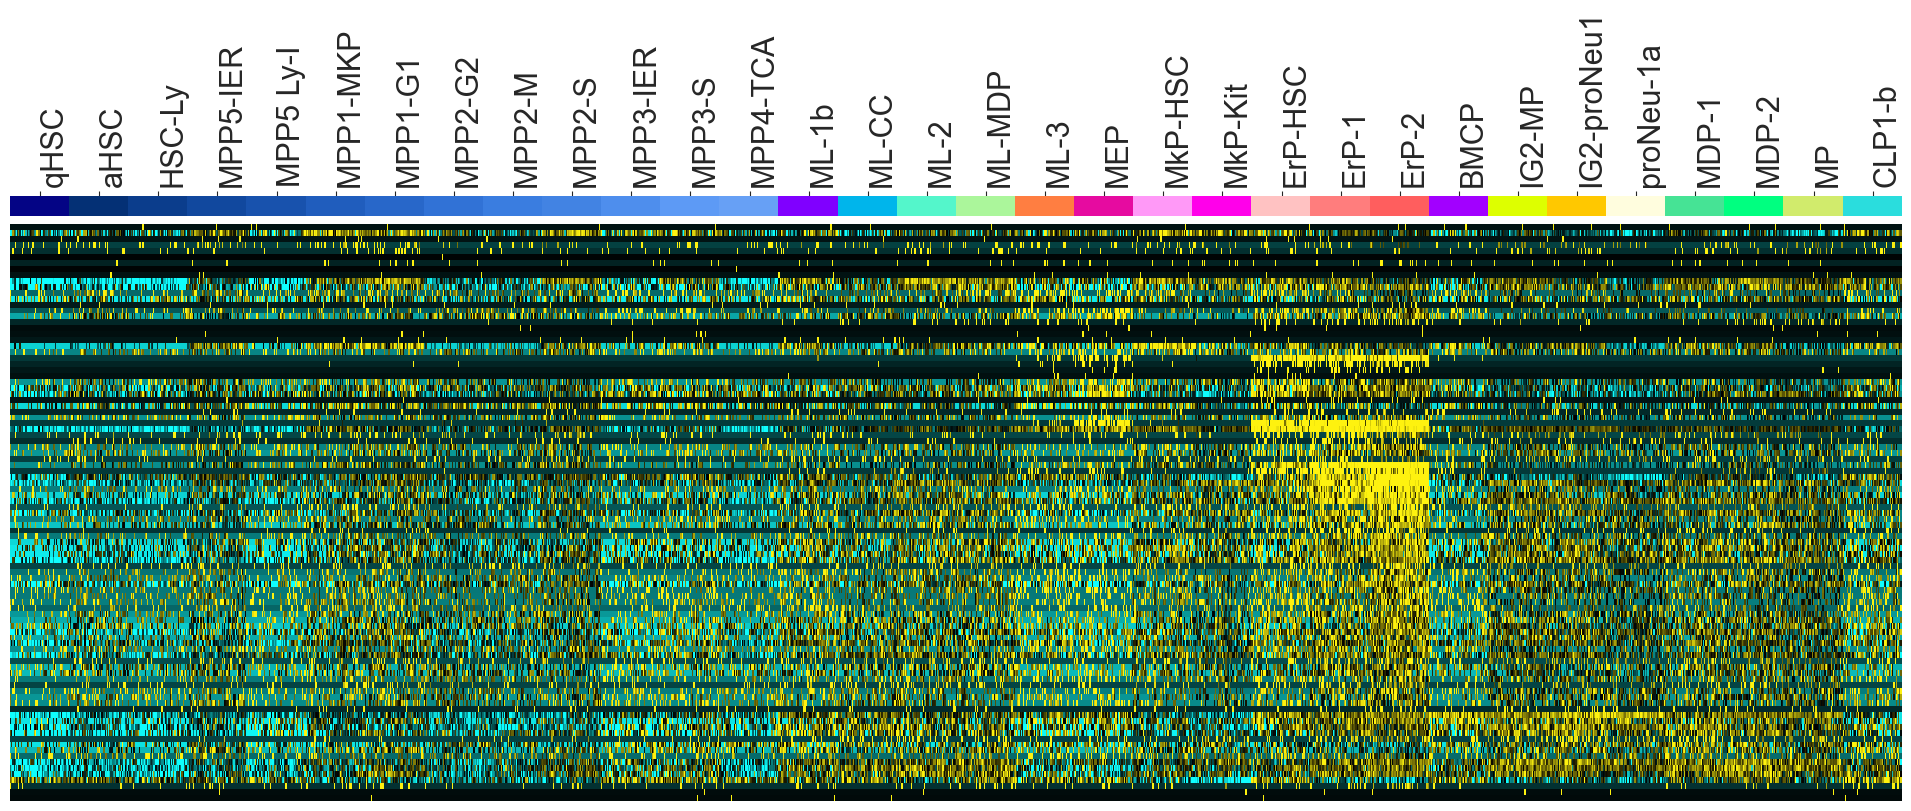

In [115]:
target = "Myc"

# Define Myc markers
list_target_genes = tf_gene_targets["Myc"]["gene"].unique()
tmp_data = pd.DataFrame(\
    adata_cite[\
        cells_to_plot.index.values, 
        list_target_genes].X.toarray(),
    index=cells_to_plot.index.values,
    columns=list_target_genes)
r_df, p_df = marker_finder(tmp_data, cells_to_plot["cluster"].values)

marker_df = pd.DataFrame({\
    "top_cluster": r_df.idxmax(axis=1),
    "r": r_df.max(axis=1)},
    index=tmp_data.columns.values)
marker_df["cluster_order"] = marker_df["top_cluster"].replace(\
    map_lvl4_to_order.to_dict())
marker_df = marker_df.sort_values(by=["cluster_order", "r"], 
    ascending=[True, False])
marker_df = marker_df.dropna()



# Plot RNA expression heatmap
from pyInfinityFlow.Plotting_Utilities import blue_black_yellow_cmap

plt.rcParams.update({'font.size': 22})

# Prepare cluster label positions
cell_tick_positions = cells_to_plot[["cluster"]]
cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))
cell_tick_positions = pd.pivot_table(\
    cell_tick_positions,
    index = "cluster",
    values = "pos",
    aggfunc = np.mean).sort_values(by="pos")

# RNA data to plot
rna_data_to_plot = zscore(tmp_data.loc[\
    cells_to_plot.index.values, 
    marker_df.index.values].T, axis=1).fillna(0)

# Cluster color bar
plot_cluster_bars = cells_to_plot[["cluster"]].T.copy()
unique_clusters = plot_cluster_bars.loc["cluster"].unique()
map_cluster_to_order = pd.Series(\
    list(range(len(unique_clusters))), 
    index=unique_clusters).to_dict()
plot_cluster_bars.loc["cluster",:] = plot_cluster_bars.loc["cluster"].replace(\
    map_cluster_to_order)
plot_cluster_bars.columns.name = None


# tmp_color_series = pd.Series('#000000', index=map_lvl4_to_color.index.values)
tmp_clusters = cells_to_plot["cluster"].unique()
tmp_color_series = map_lvl4_to_color.loc[tmp_clusters].copy()


# Construct figure
fig = plt.figure(constrained_layout=True, figsize=(19,8))
ax = fig.add_gridspec(150, 1)
ax1 = fig.add_subplot(ax[:5, 0])
ax2 = fig.add_subplot(ax[5:, 0])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap=matplotlib.colors.ListedColormap(\
                            tmp_color_series.values),
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

ax1.set_xticks(\
    ticks = cell_tick_positions["pos"].values,
    labels = cell_tick_positions.index.values, 
    ha="left")
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
    labelrotation=90)

heat2 = sns.heatmap(rna_data_to_plot, 
                        vmin=-1.5, 
                        vmax=1.5, 
                        cmap=blue_black_yellow_cmap,
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False,
                        rasterized=True,
                        ax=ax2)

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.pdf"))

tmp_table_out = pd.concat([\
    pd.DataFrame(cells_to_plot.loc[tmp_data.index.values, "cluster"]),
    tmp_data],
    axis=1)
tmp_table_out.T.to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.csv"),
    header=True, index=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 51 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'd', 'e', 'eight', 'f', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 36, 37, 38,

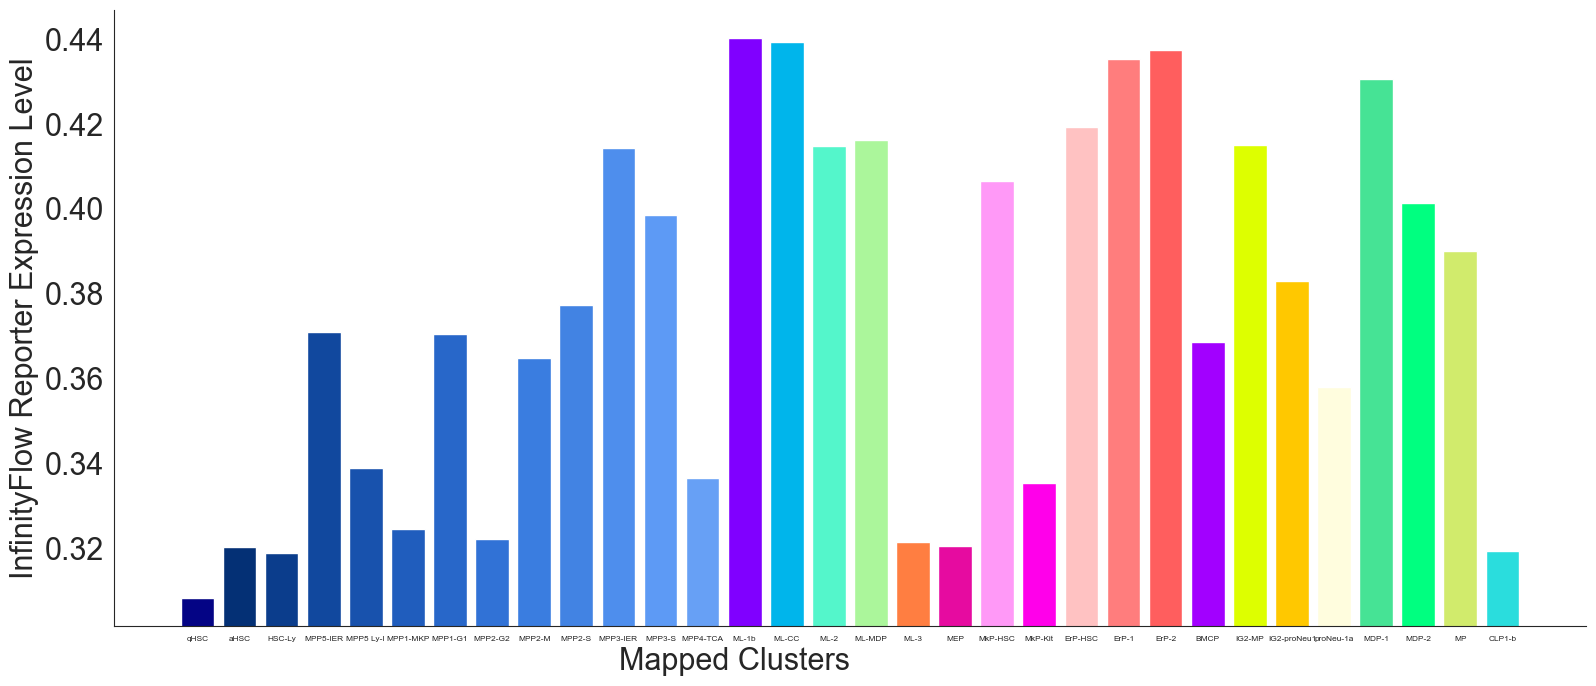

In [116]:
tmp_cluster_list = map_lvl4_to_order.loc[\
    list_clusters].sort_values().index.values
tmp_values = inflow_pbulks.loc[\
    tmp_cluster_list, 
    "Imputed_Myc-GFP"]
custom_colors = map_lvl4_to_color[tmp_cluster_list].values
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(19,8))

ax.bar(\
    np.arange(len(tmp_values)), 
    tmp_values, 
    align='center',
    color=custom_colors)

tmp_range = tmp_values.max() - tmp_values.min()
tmp_min = tmp_values.min() - (0.05*tmp_range)
tmp_max = tmp_values.max() + (0.05*tmp_range)

ax.set_ylabel('InfinityFlow Reporter Expression Level')

ax.set_xticks(np.arange(len(tmp_values)))
ax.set_xticklabels(tmp_cluster_list, size=6, ha="center")
ax.set_xlabel("Mapped Clusters", rotation = 0, ha="right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(False)
ax.yaxis.grid(False)
ax.set_ylim((tmp_min,tmp_max))

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.pdf"))

pd.DataFrame(tmp_values).to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.csv"),
    header=True, index=True, index_label="lvl4_cluster")

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'e', 'five', 'four', 'hyphen', 'i', 'k', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 'space', 't', 'three', 'two', 'u', 'y']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 51, 53, 54, 55, 68, 69, 72, 76, 78, 82, 83, 84, 85, 87, 88

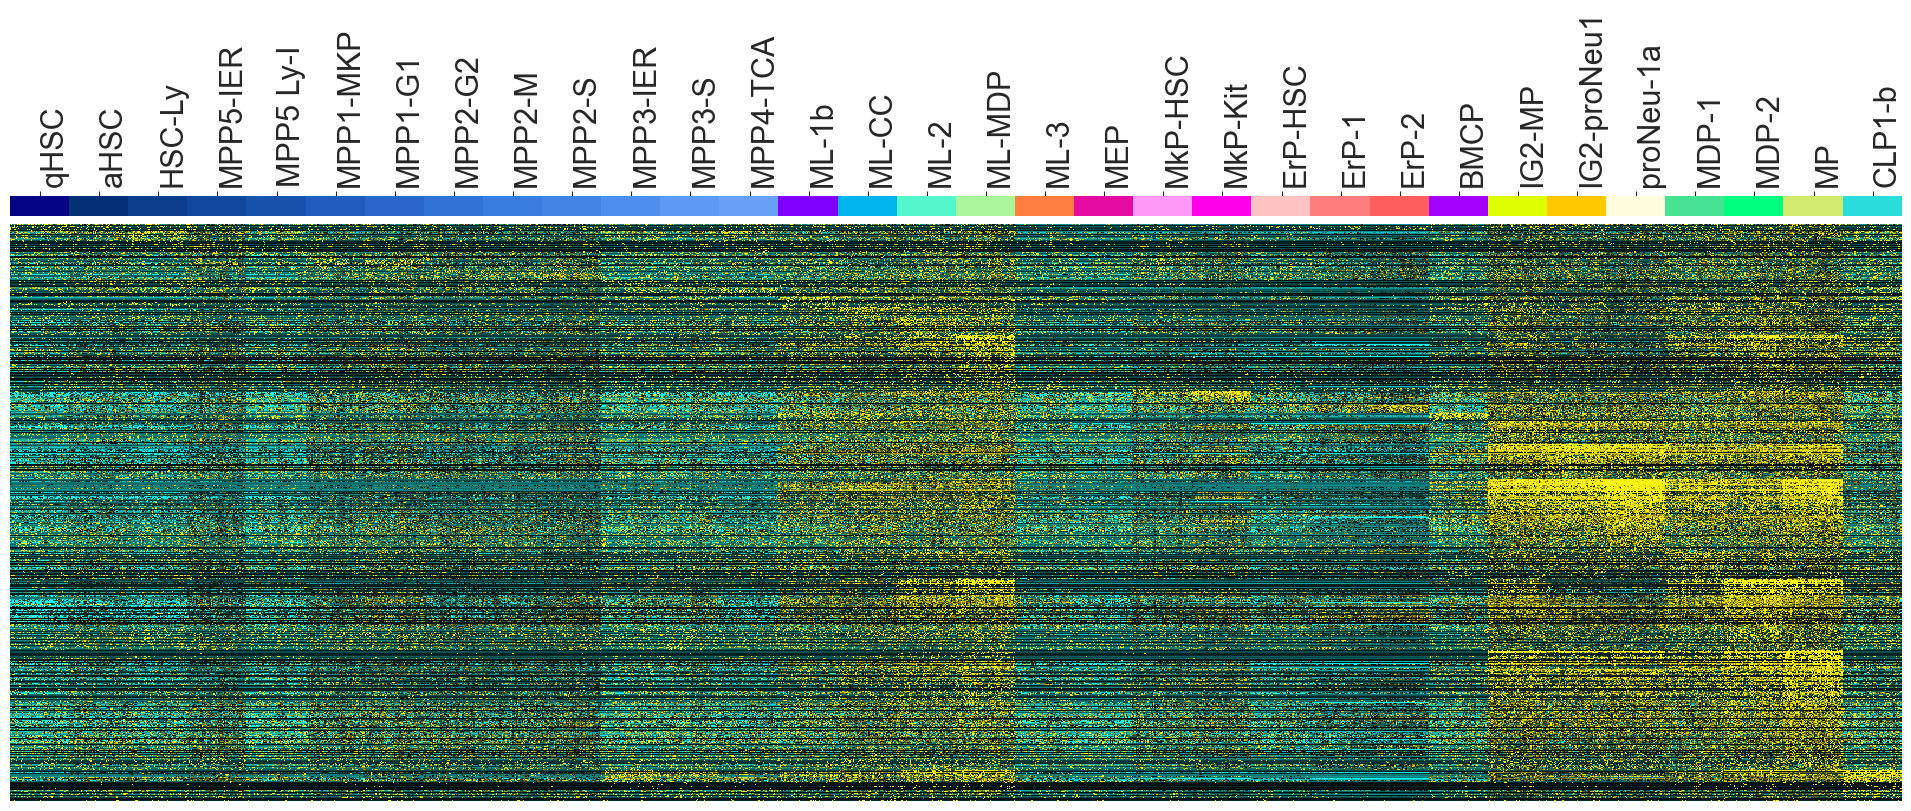

In [117]:
target = "Irf8"

# Define Irf8 markers
list_target_genes = tf_gene_targets["Irf8"]["gene"].unique()
tmp_data = pd.DataFrame(\
    adata_cite[\
        cells_to_plot.index.values, 
        list_target_genes].X.toarray(),
    index=cells_to_plot.index.values,
    columns=list_target_genes)
r_df, p_df = marker_finder(tmp_data, cells_to_plot["cluster"].values)

marker_df = pd.DataFrame({\
    "top_cluster": r_df.idxmax(axis=1),
    "r": r_df.max(axis=1)},
    index=tmp_data.columns.values)
marker_df["cluster_order"] = marker_df["top_cluster"].replace(\
    map_lvl4_to_order.to_dict())
marker_df = marker_df.sort_values(by=["cluster_order", "r"], 
    ascending=[True, False])
marker_df = marker_df.dropna()



# Plot RNA expression heatmap
from pyInfinityFlow.Plotting_Utilities import blue_black_yellow_cmap

plt.rcParams.update({'font.size': 22})

# Prepare cluster label positions
cell_tick_positions = cells_to_plot[["cluster"]]
cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))
cell_tick_positions = pd.pivot_table(\
    cell_tick_positions,
    index = "cluster",
    values = "pos",
    aggfunc = np.mean).sort_values(by="pos")

# RNA data to plot
rna_data_to_plot = zscore(tmp_data.loc[\
    cells_to_plot.index.values, 
    marker_df.index.values].T, axis=1).fillna(0)

# Cluster color bar
plot_cluster_bars = cells_to_plot[["cluster"]].T.copy()
unique_clusters = plot_cluster_bars.loc["cluster"].unique()
map_cluster_to_order = pd.Series(\
    list(range(len(unique_clusters))), 
    index=unique_clusters).to_dict()
plot_cluster_bars.loc["cluster",:] = plot_cluster_bars.loc["cluster"].replace(\
    map_cluster_to_order)
plot_cluster_bars.columns.name = None


# tmp_color_series = pd.Series('#000000', index=map_lvl4_to_color.index.values)
tmp_clusters = cells_to_plot["cluster"].unique()
tmp_color_series = map_lvl4_to_color.loc[tmp_clusters].copy()


# Construct figure
fig = plt.figure(constrained_layout=True, figsize=(19,8))
ax = fig.add_gridspec(150, 1)
ax1 = fig.add_subplot(ax[:5, 0])
ax2 = fig.add_subplot(ax[5:, 0])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap=matplotlib.colors.ListedColormap(\
                            tmp_color_series.values),
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

ax1.set_xticks(\
    ticks = cell_tick_positions["pos"].values,
    labels = cell_tick_positions.index.values, 
    ha="left")
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
    labelrotation=90)

heat2 = sns.heatmap(rna_data_to_plot, 
                        vmin=-1.5, 
                        vmax=1.5, 
                        cmap=blue_black_yellow_cmap,
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False,
                        rasterized=True,
                        ax=ax2)

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.pdf"))

tmp_table_out = pd.concat([\
    pd.DataFrame(cells_to_plot.loc[tmp_data.index.values, "cluster"]),
    tmp_data],
    axis=1)
tmp_table_out.T.to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_heatmap-{target}.csv"),
    header=True, index=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 51 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'd', 'e', 'f', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38,

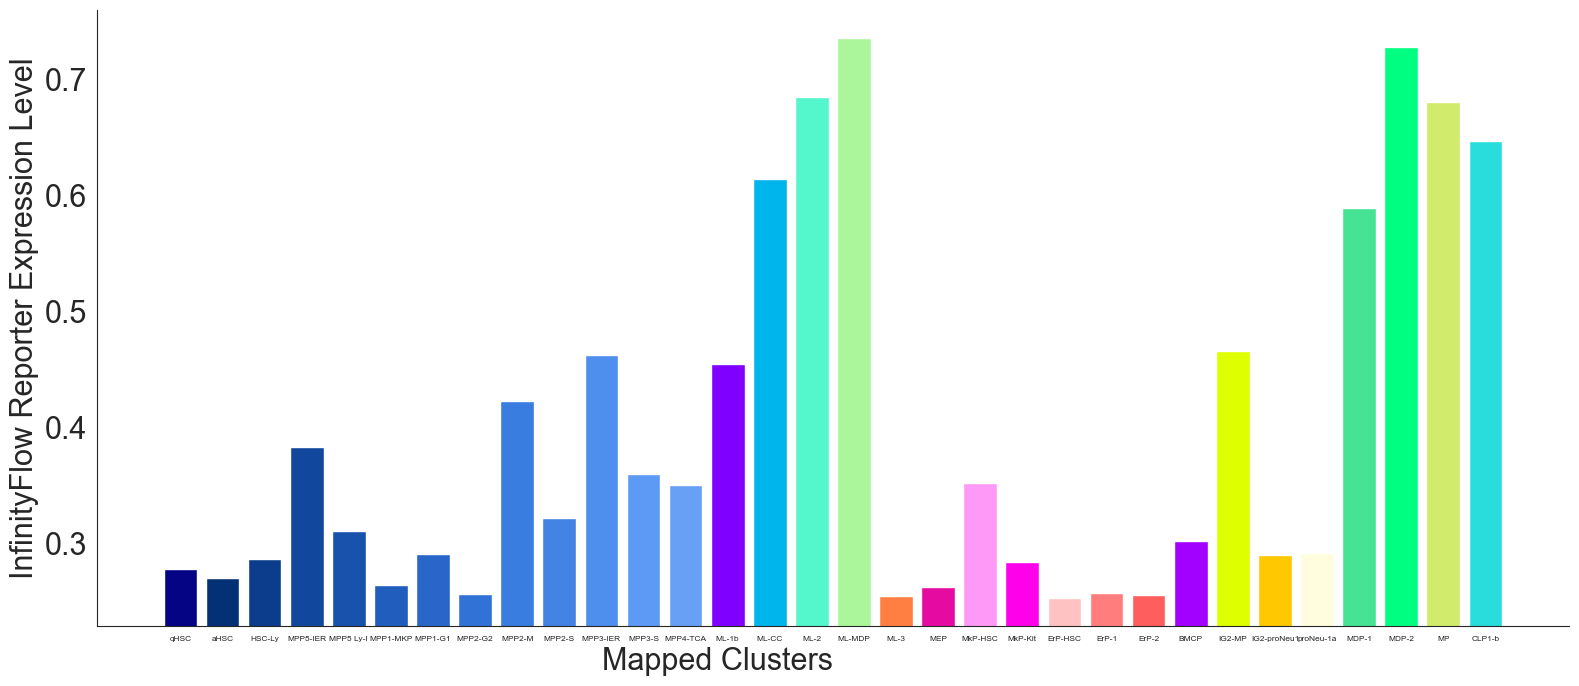

In [118]:
tmp_cluster_list = map_lvl4_to_order.loc[\
    list_clusters].sort_values().index.values
tmp_values = inflow_pbulks.loc[\
    tmp_cluster_list, 
    "Irf8"]
custom_colors = map_lvl4_to_color[tmp_cluster_list].values
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(19,8))

ax.bar(\
    np.arange(len(tmp_values)), 
    tmp_values, 
    align='center',
    color=custom_colors)

tmp_range = tmp_values.max() - tmp_values.min()
tmp_min = tmp_values.min() - (0.05*tmp_range)
tmp_max = tmp_values.max() + (0.05*tmp_range)

ax.set_ylabel('InfinityFlow Reporter Expression Level')

ax.set_xticks(np.arange(len(tmp_values)))
ax.set_xticklabels(tmp_cluster_list, size=6, ha="center")
ax.set_xlabel("Mapped Clusters", rotation = 0, ha="right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(False)
ax.yaxis.grid(False)
ax.set_ylim((tmp_min,tmp_max))

plt.savefig(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.pdf"))

pd.DataFrame(tmp_values).to_csv(os.path.join(\
    path_output_figures,
    f"infinityflow_centroid_to_marker_gene_flow_barplot-{target}.csv"),
    header=True, index=True, index_label="lvl4_cluster")

In [140]:
### Rederive TF Activity scores (~4.5 minutes)
# Read in cluster annotations to map cluster order
path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/"
cluster_anno = pd.read_csv(os.path.join(path_cite_data, "processed_files/"\
    "cluster_anno_r6_r7_lvl4_and_order.csv"))
map_lvl4_to_order = pd.Series(\
    cluster_anno["Order"].values,
    index=cluster_anno["lvl4"].values).dropna().astype(int)
map_lvl4_to_color = pd.Series(\
    cluster_anno["Color"].values,
    index = cluster_anno["lvl4"].values)
map_r7_to_lvl4 = pd.Series(\
    cluster_anno["lvl4"].values,
    index=cluster_anno["R7"].values)

path_to_cluster_conns = "output/GRN/all_genes/cluster_specific_tf_links/"
list_clusters = [i.split("_")[0] for i in os.listdir(path_to_cluster_conns)]

tf_activities = {}
for i, tmp_cluster in enumerate(list_clusters):
    print(f"{i+1}/{len(list_clusters)} Done...", end="\r", flush=True)
    tmp_conns = pd.read_feather(os.path.join(\
        path_to_cluster_conns, 
        f"{tmp_cluster}_conns.fea"))
    tf_activities[tmp_cluster] = pd.pivot_table(\
        tmp_conns, 
        index="TF_con", 
        values="con_score", 
        aggfunc=np.sum).iloc[:,0]
    
tfa = np.log2(pd.DataFrame(tf_activities).fillna(0) + 1)
tfa.index.name = None

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 18 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'F', 'T', 'c', 'eight', 'four', 'i', 'nonmarkingreturn', 'one', 'six', 'space', 't', 'two', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 36, 41, 55, 70, 76, 87, 89, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 18 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'F', 'T', 'c', 'eight', 'four', 'i', 'nonmarkin

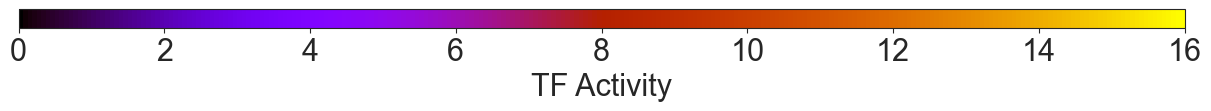

In [146]:
from matplotlib.colors import ListedColormap

def build_listed_cmap(rgb_start, rgb_center, rgb_end):
    # Define a colormap to use for marker expression heatmap
    N = 256
    vals = np.ones((N*2, 4))
    vals[:N, 0] = np.linspace(rgb_start[0]/256, rgb_center[0]/256, N)
    vals[:N, 1] = np.linspace(rgb_start[1]/256, rgb_center[1]/256, N)
    vals[:N, 2] = np.linspace(rgb_start[2]/256, rgb_center[2]/256, N)
    vals[N:, 0] = np.linspace(rgb_center[0]/256, rgb_end[0]/256, N)
    vals[N:, 1] = np.linspace(rgb_center[1]/256, rgb_end[1]/256, N)
    vals[N:, 2] = np.linspace(rgb_center[2]/256, rgb_end[2]/256, N)
    return(ListedColormap(vals))


%matplotlib inline
# pantone_2023_cmap = build_listed_cmap(\
#     rgb_start = (152,216,254),
#     rgb_center = (0,0,0),
#     rgb_end = (254,190,152))

fig, ax = plt.subplots(figsize=(12, 1), layout='constrained')

cmap = matplotlib.cm.cool
norm = matplotlib.colors.Normalize(vmin=0, vmax=16)

# fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=pantone_2023_cmap),
#              cax=ax, orientation='horizontal', label='Z-score CWM dot product')

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='gnuplot'),
             cax=ax, orientation='horizontal', label='TF Activity')

plt.savefig("output/FINAL_FIGURES_DIR/inflow_centroids_tfa_scores_heatmaps/"\
    "tf_activities_heatmap_0_16_colorbar.pdf")

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 25 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'E', 'R', 'a', 'e', 'eight', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'v', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 25, 27, 40, 53, 68, 72, 76, 79, 81, 82, 83, 85, 86, 87, 89, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 25 glyphs after
INFO:fontTools.subset:Glyph names: ['.no

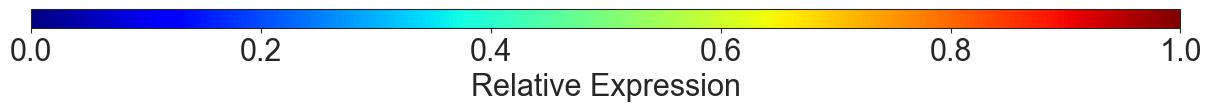

In [147]:
fig, ax = plt.subplots(figsize=(12, 1), layout='constrained')

cmap = matplotlib.cm.cool
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

# fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=pantone_2023_cmap),
#              cax=ax, orientation='horizontal', label='Z-score CWM dot product')

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='jet'),
             cax=ax, orientation='horizontal', label='Relative Expression')

plt.savefig("output/FINAL_FIGURES_DIR/inflow_centroids_tfa_scores_heatmaps/"\
    "inflow_pseudobulk_0_1_colorbar.pdf")

In [151]:
def help_plot_tfa_and_inflow_heatmap_strips(inflow_feature, tfa_feature):
    tmp_inflow_values = inflow_pbulks.loc[\
        tmp_cluster_list, 
        inflow_feature]
    tmp_inflow_values = pd.DataFrame(\
        MinMaxScaler().fit_transform(tmp_inflow_values.values.reshape(-1,1)),
        index=tmp_cluster_list,
        columns=[inflow_feature])


    tmp_tfa_values = tfa.loc[[tfa_feature], tmp_cluster_list]


    # Cluster color bar
    plot_cluster_bars = pd.Series(\
        list(range(len(tmp_cluster_list))),
        index=tmp_cluster_list)

    tmp_color_series = map_lvl4_to_color.loc[tmp_cluster_list].copy()

    # Construct figure
    fig = plt.figure(constrained_layout=True, figsize=(19,3))
    ax = fig.add_gridspec(3, 1)
    ax1 = fig.add_subplot(ax[:1, 0])
    ax2 = fig.add_subplot(ax[1:2, 0])
    ax3 = fig.add_subplot(ax[2:, 0])
    heat1 = sns.heatmap(pd.DataFrame(plot_cluster_bars.astype(np.float32)).T,
                            cmap=matplotlib.colors.ListedColormap(\
                                tmp_color_series.values),
                            yticklabels=False,
                            xticklabels=False,
                            cbar=False,
                            ax=ax1)


    heat2 = sns.heatmap(pd.DataFrame(tmp_inflow_values).T, 
                            vmin=0, 
                            vmax=1, 
                            cmap="jet",
                            xticklabels=False,
                            yticklabels=False,
                            cbar=False,
                            rasterized=False,
                            ax=ax2)


    heat3 = sns.heatmap(tmp_tfa_values, 
                            vmin=0, 
                            vmax=16, 
                            cmap="gnuplot",
                            xticklabels=False,
                            yticklabels=False,
                            cbar=False,
                            rasterized=False,
                            ax=ax3)


    plt.savefig("output/FINAL_FIGURES_DIR/inflow_centroids_tfa_scores_heatmaps/"\
        f"inflow_and_tfa_centroids-{tfa_feature}.pdf")

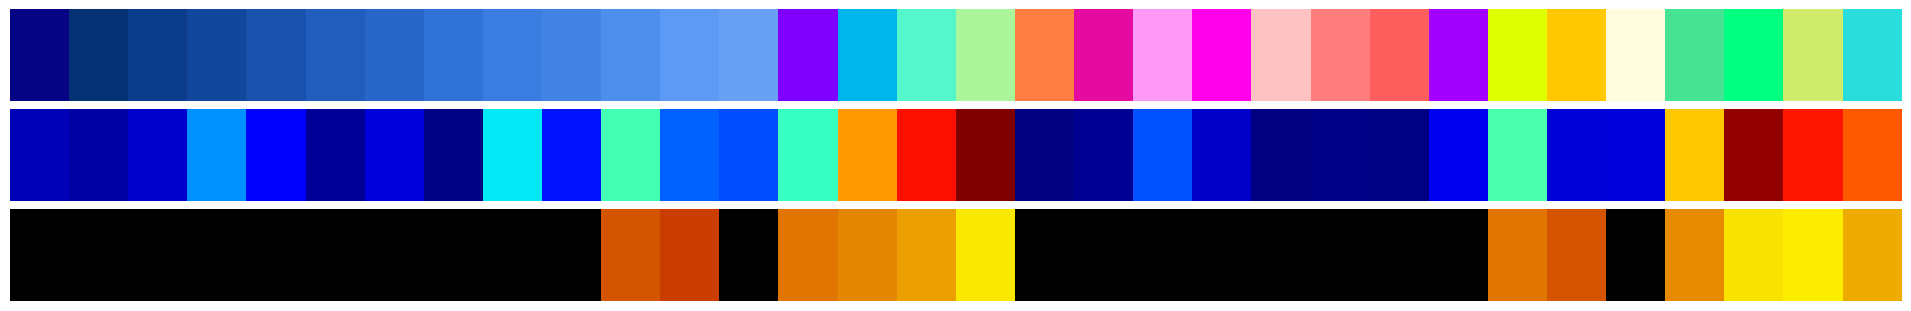

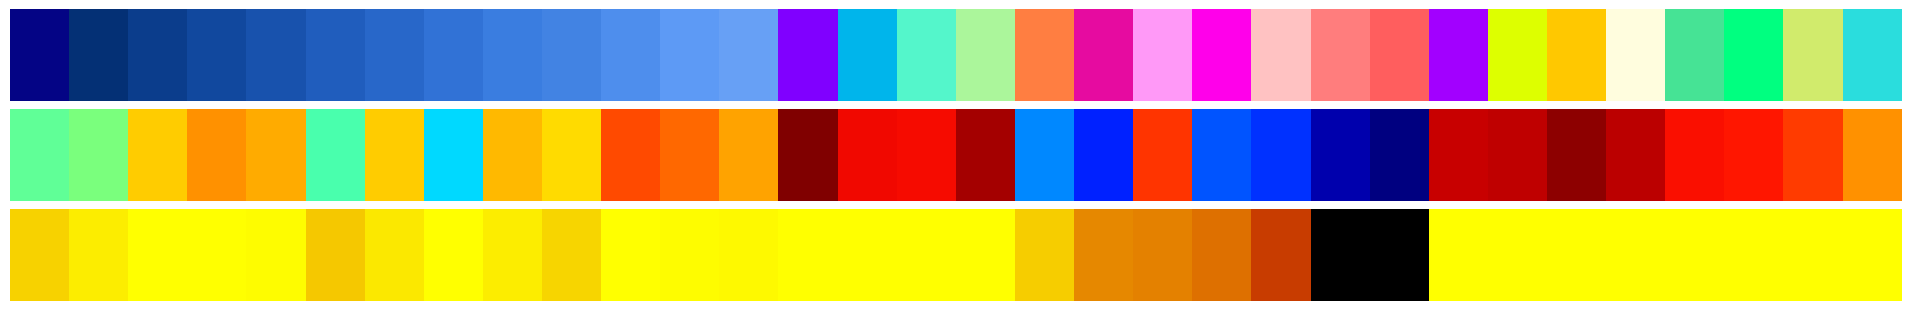

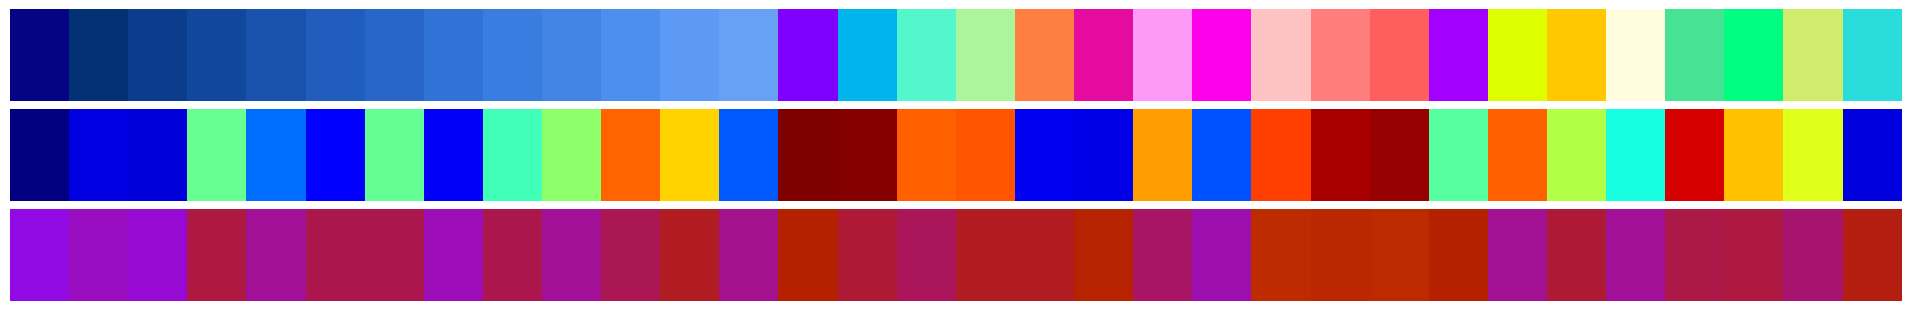

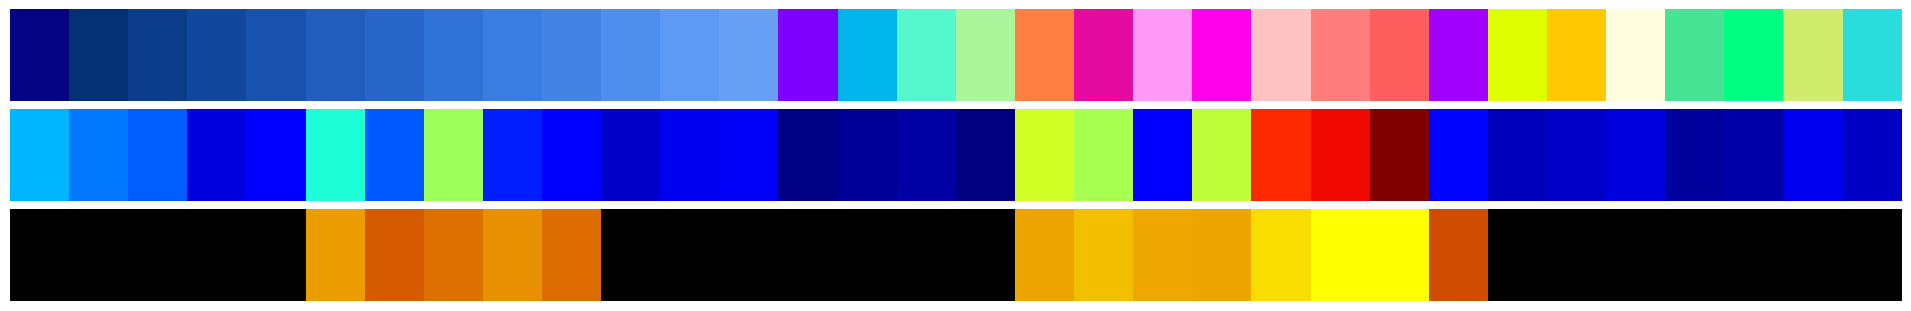

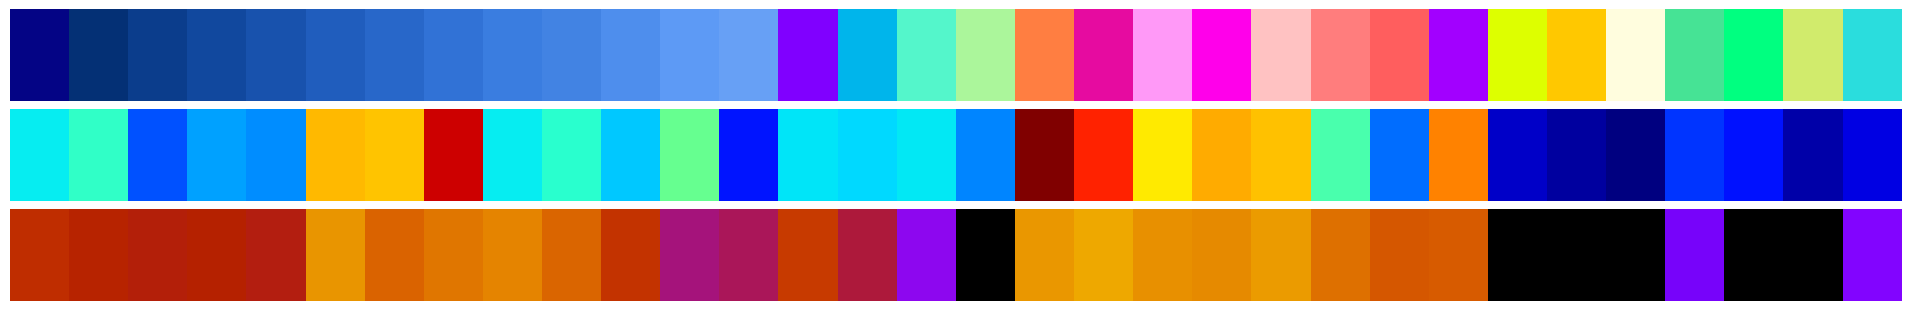

In [152]:
help_plot_tfa_and_inflow_heatmap_strips(\
    inflow_feature = "Irf8", 
    tfa_feature = "Irf8")

help_plot_tfa_and_inflow_heatmap_strips(\
    inflow_feature = "Imputed_Pu.1-YFP", 
    tfa_feature = "Spi1")

help_plot_tfa_and_inflow_heatmap_strips(\
    inflow_feature = "Imputed_Myc-GFP", 
    tfa_feature = "Myc")

help_plot_tfa_and_inflow_heatmap_strips(\
    inflow_feature = "Imputed_Gata1-mCherry", 
    tfa_feature = "Gata1")

help_plot_tfa_and_inflow_heatmap_strips(\
    inflow_feature = "Imputed_Gata2-Venus", 
    tfa_feature = "Gata2")

